# Predict everything in Kakadu with a Mamukala tree classifier

In [1]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight

#setup radar dc
dc = datacube.Datacube(config='radar.conf')

In [71]:
# load training area

qtime = ('2016-09-01', '2019-01-01')

query_m = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

mamukala = rf.bulknorm_SAR_ds(rf.load_cleaned_SAR(query_m,dc,drop_bad_scenes=True))

## fit the training area with a KMeans tree

In [3]:
import imp
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [65]:
ktr = rg.SAR_Ktree(levels=2,branches=3)

In [72]:
downsampled_ds = rf.downsample_ds(mamukala)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [73]:
downsampled_ds.vv.shape

(52, 97, 131)

In [74]:
ktr.fit(downsampled_ds)

ValueError: n_samples=1 should be >= n_clusters=3

In [ ]:
#save the tree so we can just load it back in later if the kernel dies
import pickle
with open("mamukala_fitted.pkl", "wb") as f: pickle.dump(ktr,f)

In [18]:
import gc
gc.collect()

997

Define cover class dictionary using example time-slice plots

In [19]:
mam_out = ktr.predict_dataset(mamukala)

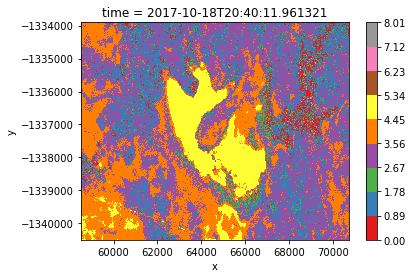

In [62]:
mam_out.isel(time=57).plot(vmin=0,vmax=8.01,levels=10,cmap='Set1')

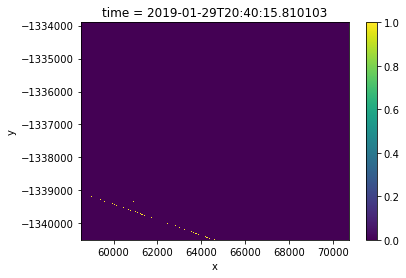

In [44]:
(mam_out==8).isel(time=135).plot()

In [63]:
#create a vectorised mapping func for application with xarray
land_dict = [2,2,2,4,3,0,2,3,1]
def map_index(i):
    return float(land_dict[int(i)]) if ~np.isnan(i) else i
vec_map = np.vectorize(map_index)

class_out = xr.apply_ufunc(vec_map,mam_out)

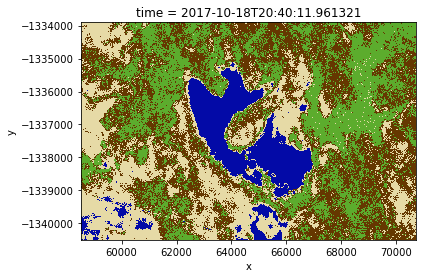

In [64]:
import seaborn as sns
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]
       ]

class_out.isel(time=57).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal, add_colorbar=False)

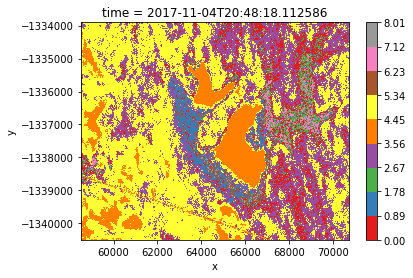

In [12]:
mam_out.isel(time=60).plot(vmin=0,vmax=8.01,cmap='Set1',levels=10)

In [ ]:
#load the big boy with dask and predict across this
from dask.distributed import Client
client=Client(memory_limit='6GB',n_workers=4)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:42561 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [2]:
#load the 'Kakadu' polygon from the Ramsar wetlands shapefile and set up a query to download data for it
shp_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/Ramsar_exploded3.shp'
shapes=fiona.open(shp_path,'r')

crs=geometry.CRS(shapes.crs_wkt)

#Kakadu is at index 12 in this shapefile
shape=shapes[12]
shape_geometry=shape['geometry']
geom=geometry.Geometry(shape_geometry,crs=crs)

query = {'geopolygon': geom,
         'time': ('2017-02-13', '2017-02-13')
         }

In [3]:
kakadu_raw = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

In [6]:
kakadu_clean = rf.denoise(kakadu_raw)
kakadu_clean['vh_over_vv']=kakadu_clean.vh/kakadu_clean.vv

In [7]:
kakadu_log = np.log(kakadu_clean)
normalised = rf.bulknorm_SAR_ds(kakadu_log)

In [8]:
model_input = rf.downsample_ds(normalised)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
import pickle
with open("mamukala_full_fit.pkl","rb") as f: ktr = pickle.load(f)

In [20]:
import imp
imp.reload(rg)
model_output = ktr.predict_dataset(model_input)

ValueError: conflicting sizes for dimension 'z': length 1 on the data but length 1653979 on coordinate 'z'

In [18]:
model_output.min()

<xarray.DataArray ()>
array(0.)

In [13]:
tree_dict = ktr.landcover_dict
predictions = model_output.copy(deep=True)
for i in range(len(tree_dict)):
    np.place(predictions.data,(model_output.data==i),tree_dict[i])

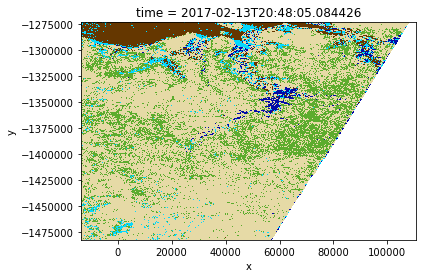

In [14]:
import seaborn as sns
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]
       ]

predictions.plot(vmin = 0, vmax = 4.01, levels=6, colors = pal, add_colorbar=False)

In [10]:
import imp
imp.reload(rf)

<module 'radar_functions' from '/g/data1a/r78/rlt118/dea-notebooks/radar_functions.py'>

In [8]:
#even with dask we are fairly limited in the number of timesteps we can do the processing on (memory leak somewhere?). Start with a few as proof of concept
for j in range(0,10):
    i = j+30
    print("loading time "+str(i))
    rawscene = kakadu_raw.isel(time=slice(i,i+1))
    clnscene = rf.denoise(rawscene)
    cln_ds = clnscene if j == 0 else xr.concat((cln_ds,clnscene),dim='time')

loading time 30
loading time 31
loading time 32
loading time 33
loading time 34
loading time 35
loading time 36
loading time 37
loading time 38
loading time 39


In [11]:
import gc
gc.collect()

719

In [13]:
cln_ds

<xarray.Dataset>
Dimensions:  (time: 10, x: 4957, y: 8348)
Coordinates:
  * y        (y) float64 -1.482e+06 -1.482e+06 ... -1.274e+06 -1.274e+06
  * x        (x) float64 -1.334e+04 -1.331e+04 ... 1.105e+05 1.106e+05
  * time     (time) datetime64[ns] 2017-03-21T20:48:08.515336 ... 2017-05-20T20:48:11.288099
Data variables:
    vh       (time, y, x) float32 dask.array<shape=(10, 8348, 4957), chunksize=(1, 8348, 4957)>
    vv       (time, y, x) float32 dask.array<shape=(10, 8348, 4957), chunksize=(1, 8348, 4957)>

In [38]:
i=0

kakscene = kakadu_raw.isel(time=slice(0,1))
kakscene = kakscene.where(kakscene!=0)
kakclean = rf.denoise(kakscene)
kakclean['vh_over_vv'] = kakclean.vh/kakclean.vv

kak_out = ktr.predict_dataset(kakclean)

In [33]:
kakscene

<xarray.Dataset>
Dimensions:  (x: 4957, y: 8348)
Coordinates:
    time     datetime64[ns] 2016-09-28T20:47:26.963719
  * y        (y) float64 -1.482e+06 -1.482e+06 ... -1.274e+06 -1.274e+06
  * x        (x) float64 -1.334e+04 -1.331e+04 ... 1.105e+05 1.106e+05
Data variables:
    vh       (y, x) float32 dask.array<shape=(8348, 4957), chunksize=(8348, 4957)>
    vv       (y, x) float32 dask.array<shape=(8348, 4957), chunksize=(8348, 4957)>
Attributes:
    crs:      EPSG:3577